In [1]:
from __future__ import print_function
from pythtb import *
import numpy as np
import matplotlib.pyplot as plt
!pip install ipympl
%matplotlib inline

E_F = -0.1
T = 1 #what about k_B?
hbar = 1

def f(E):
    return 1.0/(1+np.exp((E-E_F)/T))

def fdash(E): #derivative wrt E
    return -1/T*np.exp((E-E_F)/T)/(1+np.exp((E-E_F)/T))**2

In [2]:
# define lattice vectors
lat=[[1.0,0.0],[0.5,np.sqrt(3.0)/2.0]]
# define coordinates of orbitals in terms of lattice vectors
orb=[[1./3.,1./3.],[2./3.,2./3.]]

# make two dimensional tight-binding graphene model
my_model=tb_model(2,2,lat,orb,nspin=2)

# set model parameters
delta=0.0
t=1.0

# set on-site energies
my_model.set_onsite([-delta,delta])
# set hoppings (one for each connected pair of orbitals)
# (amplitude, i, j, [lattice vector to cell containing j])

my_model.set_hop(t, 0, 1, [ 0, 0])
my_model.set_hop(t, 1, 0, [ 1, 0])
my_model.set_hop(t, 1, 0, [ 0, 1])

# print tight-binding model
my_model.display()

N=100

k_vec = my_model.k_uniform_mesh([N,N])

---------------------------------------
report of tight-binding model
---------------------------------------
k-space dimension           = 2
r-space dimension           = 2
number of spin components   = 2
periodic directions         = [0, 1]
number of orbitals          = 2
number of electronic states = 4
lattice vectors:
 #  0  ===>  [     1.0 ,     0.0 ]
 #  1  ===>  [     0.5 ,   0.866 ]
positions of orbitals:
 #  0  ===>  [  0.3333 ,  0.3333 ]
 #  1  ===>  [  0.6667 ,  0.6667 ]
site energies:
 #  0  ===>   [[0.+0.j 0.+0.j]  [0.+0.j 0.+0.j]]
 #  1  ===>   [[0.+0.j 0.+0.j]  [0.+0.j 0.+0.j]]
hoppings:
<  0 | H |  1 + [  0 ,  0 ] >     ===>  [[1.+0.j 0.+0.j]  [0.+0.j 1.+0.j]]
<  1 | H |  0 + [  1 ,  0 ] >     ===>  [[1.+0.j 0.+0.j]  [0.+0.j 1.+0.j]]
<  1 | H |  0 + [  0 ,  1 ] >     ===>  [[1.+0.j 0.+0.j]  [0.+0.j 1.+0.j]]
hopping distances:
|  pos(  0 )  - pos(  1 + [  0 ,  0 ] ) |  =    0.5774
|  pos(  1 )  - pos(  0 + [  1 ,  0 ] ) |  =    0.5774
|  pos(  1 )  - pos(  0 + [  0 ,  1 

In [3]:
# obtain eigenvalues to be plotted
eval, evec = my_model.solve_all(k_vec,True)

E=eval.reshape(4,100,100) 
evec=evec.reshape(4,100,100,2,2)

print(evec.shape) #evec[band][k1][k2][j][nspin]
evec = evec[:,:,:,0,:]+evec[:,:,:,1,:] #eliminating j- naive sum

(4, 100, 100, 2, 2)


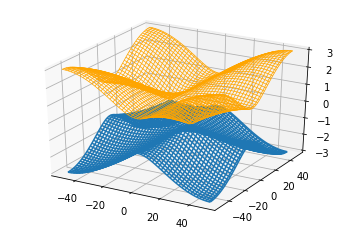

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = y = np.linspace(-50, 50, 100)
k_X, k_Y = np.meshgrid(x, y)


ax.plot_wireframe(k_X, k_Y, E[0])
ax.plot_wireframe(k_X, k_Y, E[2],0.75,color='orange')

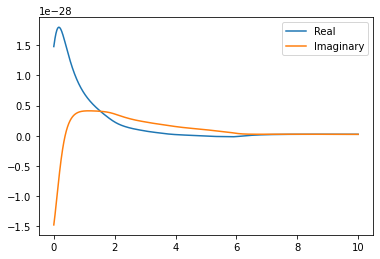

In [6]:
constants = 1+1j # fitting-ish parameter
spinfrac = 1 # eigenspinor-pauli-matrix-thing factor

def kubo_arr(E, omega, Gamma):
    conductivity = np.zeros(shape=(omega.shape),dtype=complex)
    for i in range(len(omega)):
        ku=0
        for n in [1,2]: #band index n
            for m in [1,2]: #band index m
                
                spinfrac = (np.absolute(np.sum(np.conj(evec[n])*np.flip(evec,axis=3)[m],axis=2)))**2
                if n!=m:
                    contribution = (f(E[m])-f(E[n]))/(E[m]-E[n])
                    if(len(np.where(E[m]-E[n]==0)[0])>0):
                        contribution = -fdash(E[n])
                else:
                    contribution = -fdash(E[n])

                ku += contribution*spinfrac/(hbar*omega[i]+Gamma*1j-E[m]+E[n])
        conductivity[i]=constants*np.sum(ku)
            
    return conductivity

freq = np.linspace(0,10,1000)
sigma = kubo_arr(E, freq, 0.4)
plt.plot(freq,sigma.real,label='Real')
plt.plot(freq,sigma.imag,label='Imaginary')
plt.legend()